In [8]:
# Imports
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pyeeg import *
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import tsfresh
import pandas as pd
from utils.split import split_features_and_labels

In [3]:
# Things associated with the GAMEEMO dataset
electrodes = 'AF3 AF4 F3 F4 F7 F8 FC5 FC6 O1 O2 P7 P8 T7 T8'.split(' ')
sample_rate = 128

In [ ]:
# In summary, the resulting features are an array containing raw EEG data split into 5-second intervals. 
# (dimensionality of n subjects*n trials*slice_amt x n_electrodes x 128*5), which I'll call batch size.
# and the labels are an array containing valence and arousal for each 5-second interval.
# (dimensionality of n subjects*n trials*slice_amt x 2)
eeg_splitted_features = np.load('gameemo_features.npy')
eeg_splitted_labels = np.load('gameemo_labels.npy')
print(eeg_splitted_features.shape)

In [ ]:
#eeg_splitted_features, eeg_splitted_labels = split_features_and_labels(eeg_splitted_features, eeg_splitted_labels, sample_rate, 30)

drop_locs = np.any(eeg_splitted_labels <0, axis=-1)
eeg_splitted_features = eeg_splitted_features[np.logical_not(drop_locs)]
eeg_splitted_labels = eeg_splitted_labels[np.logical_not(drop_locs)]

In [ ]:
# Labels are originally scaled between 1 and 5. We transform them between 0 and 1.
scaled_labels = eeg_splitted_labels
#scaled_labels = MinMaxScaler().fit_transform(eeg_splitted_labels)
valence_labels = scaled_labels[:, 0]
arousal_labels = scaled_labels[:, 1]

In [ ]:

# Extract power bands; we first flatten the first two dimensions to obtain a 2D array of voltage timeseries, we calculate band power for each electrode separately, then get the electrode dimension back. This gives us a dimensionality of (batch size x n electrodes x n bands)
reshaped_features = np.reshape(eeg_splitted_features, [eeg_splitted_features.shape[0]*eeg_splitted_features.shape[1], eeg_splitted_features.shape[2]])
extracted_powers = np.asarray([bin_power(X=feature, Band=[0.5, 4, 7, 12, 30, 50],  Fs=sample_rate) for feature in reshaped_features])[:, 0, :]
extracted_powers = np.reshape(extracted_powers, [eeg_splitted_features.shape[0], eeg_splitted_features.shape[1], extracted_powers.shape[1]])
print(extracted_powers.shape)


In [ ]:
extracted_entropy = np.asarray([dfa(feature) for feature in reshaped_features])
print(extracted_entropy.shape)

In [ ]:
# Then we flatten the last two dimensions, leaving some number of bands per electrode as the final feature for each data point.
final_features = np.reshape(extracted_powers, [extracted_powers.shape[0], extracted_powers.shape[1]*extracted_powers.shape[2]])

In [15]:
# We do k-fold cross validation, meaning that we hold out 10% of the data, train on the other 90%, and evaluate the model performance on the original 10%.
# We repeat this process k times. 
# As we can see, there is some overfitting as the train R^2 is much higher than the test R^2.
kf = KFold(n_splits=10, shuffle=True)
i = 0

all_predictions_arousal = np.zeros((final_features.shape[0], ))
for train_index, test_index in kf.split(final_features):
    x_train = final_features[train_index]
    y_train = arousal_labels[train_index]
    x_test = final_features[test_index]
    y_test = arousal_labels[test_index]

    xgb =  XGBRegressor()
    xgb.fit(x_train, y_train)
    

    print('Fold number ' + str(i))
    y_pred = xgb.predict(x_train)
    print('Train R^2: ' + str(r2_score(y_train, y_pred)))
    y_pred = xgb.predict(x_test)
    print('Test R^2: ' + str(r2_score(y_test, y_pred)))

    all_predictions_arousal[test_index] = y_pred
    i += 1

Fold number 0
Train R^2: 0.9999583064252505
Test R^2: 0.5441731340753355
Fold number 1
Train R^2: 0.9999679100992879
Test R^2: 0.5760470432704068
Fold number 2
Train R^2: 0.9999779575902946
Test R^2: 0.5699781332681779
Fold number 3
Train R^2: 0.9999619600333433
Test R^2: 0.5683021088711764
Fold number 4
Train R^2: 0.9999561028656037
Test R^2: 0.5846729330058867
Fold number 5
Train R^2: 0.9999470079085018
Test R^2: 0.6135480508090585
Fold number 6
Train R^2: 0.9999693423724281
Test R^2: 0.669285415634671
Fold number 7
Train R^2: 0.9999671439391458
Test R^2: 0.6284077397309618
Fold number 8
Train R^2: 0.9999689654969879
Test R^2: 0.4599181662237367
Fold number 9
Train R^2: 0.9999861807728756
Test R^2: 0.6731700716478124


In [16]:
# We do k-fold cross validation, meaning that we hold out 10% of the data, train on the other 90%, and evaluate the model performance on the original 10%.
# We repeat this process k times. 
# As we can see, there is some overfitting as the train R^2 is much higher than the test R^2.
kf = KFold(n_splits=10, shuffle=True)
i = 0

all_predictions_valence = np.zeros((final_features.shape[0], ))
for train_index, test_index in kf.split(final_features):
    x_train = final_features[train_index]
    y_train = valence_labels[train_index]
    x_test = final_features[test_index]
    y_test = valence_labels[test_index]

    xgb =  XGBRegressor()
    xgb.fit(x_train, y_train)
    

    print('Fold number ' + str(i))
    y_pred = xgb.predict(x_train)
    print('Train R^2: ' + str(r2_score(y_train, y_pred)))
    y_pred = xgb.predict(x_test)
    print('Test R^2: ' + str(r2_score(y_test, y_pred)))
    all_predictions_valence[test_index] = y_pred
    i += 1

Fold number 0
Train R^2: 0.9999623654119671
Test R^2: 0.4116389866484913
Fold number 1
Train R^2: 0.9999359999779573
Test R^2: 0.531523245134562
Fold number 2
Train R^2: 0.9999618633900599
Test R^2: 0.45481184976210876
Fold number 3
Train R^2: 0.99996445785451
Test R^2: 0.3389569962532111
Fold number 4
Train R^2: 0.9999599355285339
Test R^2: 0.29071138806816776
Fold number 5
Train R^2: 0.9999618165734538
Test R^2: 0.43984084126151757
Fold number 6
Train R^2: 0.9999666594688719
Test R^2: 0.4176683623845878
Fold number 7
Train R^2: 0.9999397544869826
Test R^2: 0.3795189796313745
Fold number 8
Train R^2: 0.9999145517699043
Test R^2: 0.48015678743998336
Fold number 9
Train R^2: 0.9999315066957633
Test R^2: 0.42844178361700624


Text(0, 0.5, 'Arousal')

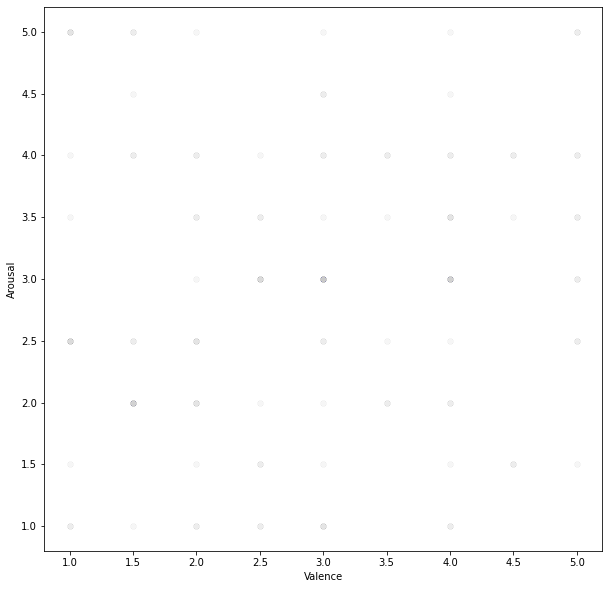

In [17]:
# A plot of the label space, the valence and arousal.
# The darker the blue, the more total labels are stacked on top of that point.

plt.figure(figsize=(10, 10))
plt.scatter(scaled_labels[:, 0], scaled_labels[:, 1], alpha=0.005)
plt.xlabel('Valence')
plt.ylabel('Arousal')

Text(0, 0.5, 'Predicted arousal')

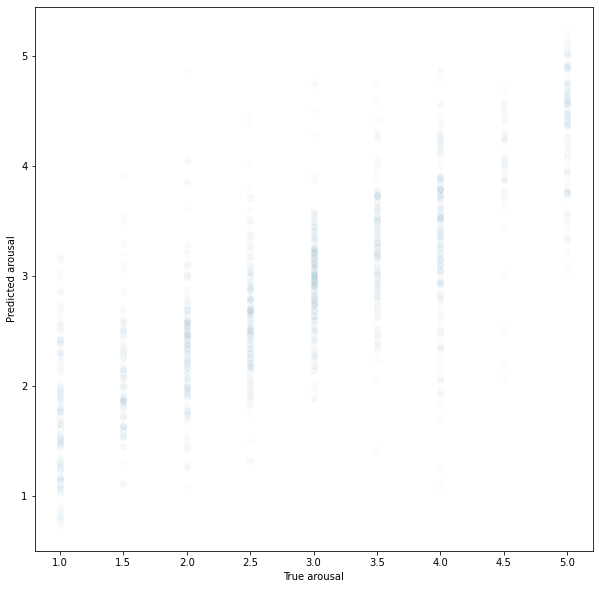

In [18]:
plt.figure(figsize=(10, 10))

plt.scatter(arousal_labels, np.expand_dims(all_predictions_arousal,axis=-1), alpha=0.02)
plt.xlabel('True arousal')
plt.ylabel('Predicted arousal')

Text(0, 0.5, 'Predicted valence')

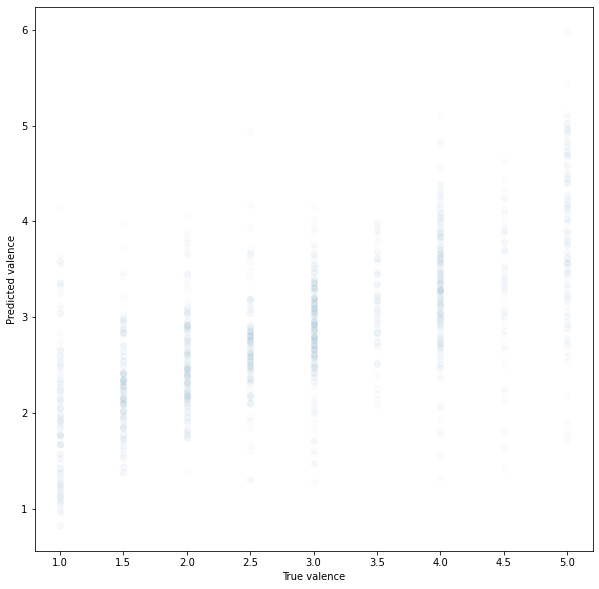

In [19]:
plt.figure(figsize=(10, 10))
plt.scatter(valence_labels, all_predictions_valence, alpha=0.02)
plt.xlabel('True valence')
plt.ylabel('Predicted valence')